The nv center paper https://pubs.aip.org/avs/aqs/article/2/2/024701/997281/Introduction-to-quantum-optimal-control-for has an example of a control pulse for just the zeeman term of the Hamiltonian.  I want to replicate this and put it in GRAPE to try to understand how to deal with the B-field being aligned or not aligned with the NV-axes.

In [1]:
import matplotlib.pyplot as plt
import time
import numpy as np
from numpy import pi

from scipy.constants import physical_constants, h
from dataclasses import dataclass

from qutip import *
from qutip.control import *
from qutip.qip.operations import rx
from qutip.qip.operations import ry
from qutip.qip.operations import rz

from qutip.control.grape import plot_grape_control_fields, _overlap
from qutip.control.cy_grape import cy_overlap
from qutip.control.grape import cy_grape_unitary, grape_unitary_adaptive

from scipy.interpolate import interp1d
from qutip.ui.progressbar import TextProgressBar

The following cells are to write the Hamiltonian using the rotating wave approximation

In [2]:
#defining constants in hamiltonian
h= 6.582119 * 1e-16 #eV * sec 
Bperpendicular = 10 #mT
Bparallel = 10 #mT
gammanv = 2*np.pi*28 * 1000000 #Hz/mT
omeganv = Bparallel * gammanv
omegamw = 1000000000 #Hz
Delta = omeganv - omegamw
#Delta
Omega = Bperpendicular * gammanv
Omega

1759291886.0102842

In [3]:
h=1
H0= h*Delta*sigmaz() + h*sigmax() + h*sigmay()
#H0 = h*Delta*sigmaz()
H0

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 7.59291886e+08+0.j  1.00000000e+00-1.j]
 [ 1.00000000e+00+1.j -7.59291886e+08+0.j]]

In [4]:
R = 100
H_ops = [Omega*sigmax(), Omega*sigmay()]

#Labels for the graph
H_labels = [r'$u_{x}$',
            r'$u_{y}$',
        ]

In [5]:
#writing out starting state for single qubit

psi0 = basis(2, 0)
print (psi0)

Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[1.]
 [0.]]


In [6]:
#creating transform matrix

phi=(np.pi)
#U = 1*rx(phi)
U = sigmax()
U

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0. 1.]
 [1. 0.]]

In [25]:
100/Omega

5.6841051104248334e-08

In [31]:
times = np.linspace(0, 2*Omega, 100)
times

array([0.00000000e+00, 3.55412502e+07, 7.10825004e+07, 1.06623751e+08,
       1.42165001e+08, 1.77706251e+08, 2.13247501e+08, 2.48788752e+08,
       2.84330002e+08, 3.19871252e+08, 3.55412502e+08, 3.90953752e+08,
       4.26495003e+08, 4.62036253e+08, 4.97577503e+08, 5.33118753e+08,
       5.68660004e+08, 6.04201254e+08, 6.39742504e+08, 6.75283754e+08,
       7.10825004e+08, 7.46366255e+08, 7.81907505e+08, 8.17448755e+08,
       8.52990005e+08, 8.88531256e+08, 9.24072506e+08, 9.59613756e+08,
       9.95155006e+08, 1.03069626e+09, 1.06623751e+09, 1.10177876e+09,
       1.13732001e+09, 1.17286126e+09, 1.20840251e+09, 1.24394376e+09,
       1.27948501e+09, 1.31502626e+09, 1.35056751e+09, 1.38610876e+09,
       1.42165001e+09, 1.45719126e+09, 1.49273251e+09, 1.52827376e+09,
       1.56381501e+09, 1.59935626e+09, 1.63489751e+09, 1.67043876e+09,
       1.70598001e+09, 1.74152126e+09, 1.77706251e+09, 1.81260376e+09,
       1.84814501e+09, 1.88368626e+09, 1.91922751e+09, 1.95476876e+09,
      

In [32]:
me_result = mesolve(result.H_t, startingstate, times, c_ops, e_ops,options=Options(nsteps=10000000))

Exception: tlist not sampled uniformly

In [9]:
#definiting U0 ??????
T = 100/Omega
times = np.linspace(0, T, 100)
u0 = np.array([np.random.rand(len(times)) * 2 * pi * 0.005 for _ in range(len(H_ops))])
u0 = [np.convolve(np.ones(10)/10, u0[idx,:], mode='same') for idx in range(len(H_ops))]

In [10]:
#doing GRAPE!
result = cy_grape_unitary(U, H0, H_ops, R, times, u_start=u0, eps=2*pi/T, phase_sensitive=False,
                          progress_bar=TextProgressBar())

10.0%. Run time:   2.43s. Est. time left: 00:00:00:21
20.0%. Run time:   4.60s. Est. time left: 00:00:00:18
30.0%. Run time:   6.76s. Est. time left: 00:00:00:15
40.0%. Run time:   8.89s. Est. time left: 00:00:00:13
50.0%. Run time:  11.08s. Est. time left: 00:00:00:11
60.0%. Run time:  13.19s. Est. time left: 00:00:00:08
70.0%. Run time:  15.45s. Est. time left: 00:00:00:06
80.0%. Run time:  17.64s. Est. time left: 00:00:00:04
90.0%. Run time:  19.86s. Est. time left: 00:00:00:02
Total run time:  21.87s


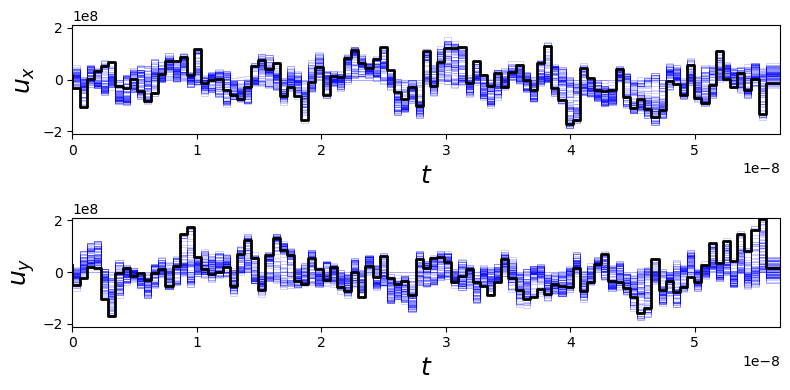

In [11]:
#Plotting pulse sqeuences from GRAPE
plot_grape_control_fields(times, result.u[:,:,:] / (2 * pi), H_labels, uniform_axes=True);

In [ ]:
from scipy.optimize import curve_fit
def sine(x, a, b,d):
    return a * np.sin(x*b) +d
def cosine(x, a, b,d):
    return a * np.cos(x*b) +d


In [ ]:
pulse1 = result.u[-1,0] / (2 * pi)
plt.plot(times,pulse1,'b.')

In [ ]:
pulse2 = result.u[-1,1] / (2 * pi)
#plt.plot(times,pulse2,'g.')

In [ ]:
p0 = [0.1,1,0.1]
popt, pcov = curve_fit(sine, pulse1, times,p0,bounds=((0,-3,-0.1),(0.1,3,0.1)))


print(popt)


In [ ]:
plt.plot(times, sine(times, *popt), 'r-',
         label='fit: amplitude=%5.3f, frequency=%5.3f,offset=%5.3f' %tuple(popt))
plt.plot(times,pulse1,'b.')
plt.legend()
plt.show()

In [12]:
startingstate = Qobj([[1.],
                      [0.]])
result.U_f

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[-0.75407535-0.50838925j -0.12270203+0.39731056j]
 [ 0.12270197+0.3973106j  -0.75407545+0.50838918j]]

In [13]:
finalstate = result.U_f*startingstate
finalstate

Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[-0.75407535-0.50838925j]
 [ 0.12270197+0.3973106j ]]

In [14]:
finalstateideal = U*startingstate
finalstateideal

Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[0.]
 [1.]]

In [15]:
#c_ops = []
#e_ops = [sigmax(), sigmay(), sigmaz()]
#U_f_numerical = propagator(result.H_t, times, c_ops, args={})
#me_result = mesolve(result.H_t, psi0, times, c_ops, e_ops)
b = Bloch() 

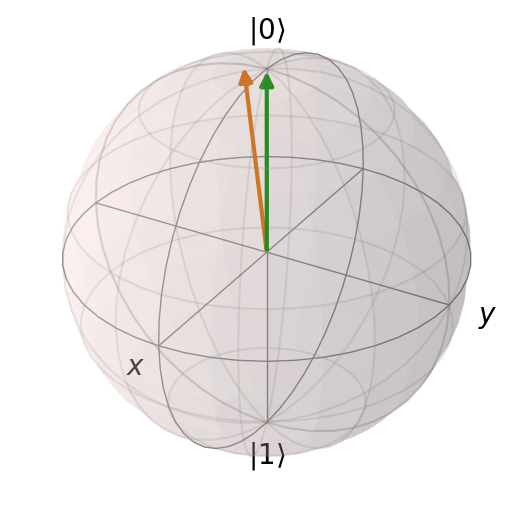

In [16]:
#plotting bloch sphere

#b.add_points(me_result.expect)
b.add_states(startingstate)
b.add_states(finalstate)
b.show()

In [17]:
c_ops = []
e_ops = [sigmax(), sigmay(), sigmaz()]
me_result = mesolve(result.H_t, startingstate, times, c_ops, e_ops)
b = Bloch()

b.add_points(me_result.expect)

b.add_states(startingstate)
b.add_states(U * startingstate)
b.render()

C:\ProgramData\Anaconda3\lib\site-packages\scipy\integrate\_ode.py:1011: UserWarning: zvode: Excess work done on this call. (Perhaps wrong MF.)
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


Exception: ODE integration error: Try to increase the allowed number of substeps by increasing the nsteps parameter in the Options class.

In [ ]:
len(times)

In [ ]:
me_result.expect

In [24]:
me_result = mesolve(result.H_t, startingstate, times, c_ops, e_ops,options=Options(nsteps=10000000))

Exception: ODE integration error: Try to increase the allowed number of substeps by increasing the nsteps parameter in the Options class.